# SeasFire Datacube access and basic analytics

This notebook shows basic utilities to load and process the SeasFire DataCube with xarray. It contains basic instructions showing how to access, process and visualize the data.

## Initial Imports

We start by importing the libraries we need. Make sure to have them installed in your system, using conda or pip packaging systems.

In [291]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import xarray as xr
import zarr

## Download and Access DataCube

We download the datacube from SeasFire DataCube in the form of a zarr file from Zenodo and Google drive.  
- Download complete dataset from [Zenodo](https://zenodo.org/record/6834585) 


In [ ]:
# Instructions to download from Zenodo (100 GB Zarr file)

# Download zipped cube
!wget https://zenodo.org/record/6834585/files/SeasFireCube8daily.zip
    
# Extract from zip file
!unzip SeasFireCube8daily.zip

!ls


--2022-07-15 15:09:44--  https://zenodo.org/record/6834585/files/SeasFireCube8daily.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35204581431 (33G) [application/octet-stream]
Saving to: ‘SeasFireCube8daily.zip’

SeasFireCube8daily.   1%[                    ] 393,27M  8,48MB/s    eta 37m 0s 

In [ ]:
# Instructions to download a subset from Google Drive (2-10 GB Zarr file)
# dataset = xr.open_zarr(path_to_drive, consolidated = False)

In [292]:
# First method (Download and access)
#!wget -r -m ftp://ftp.bgc-jena.mpg.de/pub/outgoing/lalonso/SeasFireCube
dataset = xr.open_zarr(r"C:\wgetdown\ftp.bgc-jena.mpg.de\pub\outgoing\lalonso\SeasFireCube\SeasFireCube8daily.zarr", consolidated = False)

## Datacube Dimensions 

In [294]:
dataset

<xarray.Dataset>
Dimensions:      (time: 966, latitude: 720, longitude: 1440)
Coordinates:
  * latitude     (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude    (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time         (time) datetime64[ns] 2001-01-01T12:00:00 ... 2021-12-27T12:...
Data variables: (12/19)
    BurntArea    (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    LST_Day_CMG  (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    NDVI         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    rH_cf        (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    skt          (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ssr          (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...           ...
    var1         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    var2         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    var3         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    var4         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd_cf       (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>

We easily observe that the dataset has three(3) dimensions, which are the 
- longitude(x)
- latitude(y) 
- time.

Spatio-Temporal Coverage:
- 2001 to 2021 ( 21 years) 
- Global 
- 26 input variables
- 4 target variables 
- static variables do not match the weekly resolution of the rest of the dataset 
- there are missing years for some variables, refer to the documentation for more information 
-  We have a  720 × 1440 rasters for each 8-day period of time. This is why time dimension is 966.
- Each input variable contains a numpy array with dimensions 966x720x1440 **(time * x * y )** 

## Plotting and Analytics

In this section, we'll see some basic functionality showing how to select and visualize the variables in the datacube.
1. Plotting the 2 metre temperature in the whole earth at specific 8-days period of time
2. Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all years between 2001 and 2021. We can plot both the time-series of the temperature and a histogram of the values
3. Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all periods in the year 2021.
4.  PLotting the wind speed for the whole earth for a series of 8-days time periods.
5. Plotting the relative humidity for the whole earth for the same time periods as above.
6. Plotting the BurntArea for the whole earth for the same time periods as above. 

In [308]:
def select_spatio_temporal_data(dataset, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to select a subset of the cube.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1    
    '''
    
    if(latitude == -1 and longitude == -1):
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps))
    
    return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=latitude, longitude=longitude)

In [309]:
def select_variable_data(dataset, variable_name):
    '''
    Desc
    ----
    Method to select a particular variable (such as relaive humidity, windspeed, sst etc)
    from the DataCube.
    
    Args
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    '''
    
    return dataset[variable_name]

In [316]:
def earth_graph(dataset, variable_name, initial_timestep, timesteps, latitude=-1, longitude=-1, col_wrap=1):
    '''
    Desc
    ----
    Method to plot whole earth for specific variable for specific time interval.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    col_wrap: int
        *how many graphs will be plotted i the same row
    latitude: int
        * value = -1, that is whole earth
    longitude: int
        * value = -1, that is whole earth
    '''
    
    if (timesteps==1):

        select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                    initial_timestep, 
                                    timesteps, 
                                    latitude, 
                                    longitude).plot()
    else:
        
        select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                    initial_timestep, 
                                    timesteps, 
                                    latitude, 
                                    longitude).plot(x="longitude", 
                                                    y="latitude", 
                                                    col="time", 
                                                    col_wrap=col_wrap)

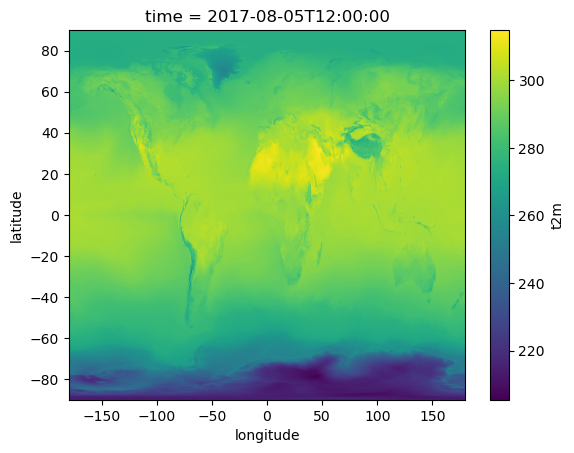

In [337]:
earth_graph(dataset, 't2m', 763, 1, -1, -1)

In [317]:
def trend_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to plot a specific point in earth for specific time interval and variable.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
    '''
    
    plt.figure(figsize=(10, 4))
    select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                initial_timestep, 
                                timesteps, 
                                latitude, 
                                longitude).plot(linewidth=2, color='#5f0f40')
    plt.show()

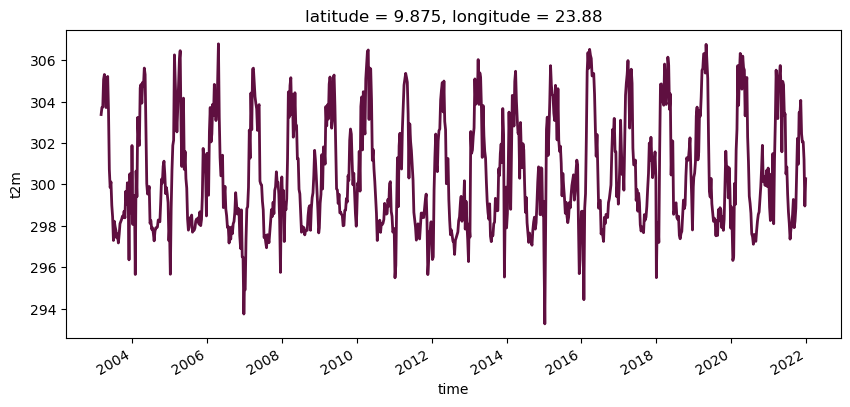

In [338]:
trend_graph(dataset, 't2m', 100, 900, 320, 815)

In [318]:
def hist_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to plot a histogram for a specific variable in a specific point in earth for a given time interval.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
    '''
    
    plt.figure(figsize=(5, 3))
    select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                initial_timestep, 
                                timesteps, 
                                latitude, 
                                longitude).plot.hist(color='#0f4c5c')
    plt.show()  

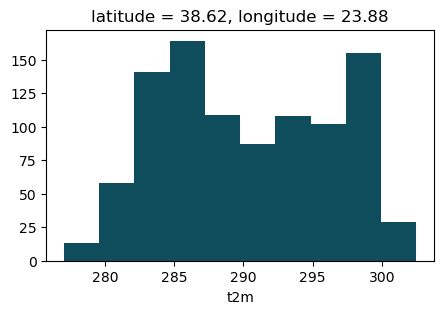

In [339]:
hist_graph(dataset, 't2m', 0, 966, 205, 815)

In [327]:
def plot_graphs(dataset, variable_name, initial_timestep, timesteps, latitude, longitude, col_wrap=1):
    '''
    Desc
    ----
    Method to plot graphs for specific variables from the dataset.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1 
    col_wrap: int
        * how many graphs will be plotted i the same row
    '''
    
    assert timesteps >= 1, 'timesteps must be larger or equal to one'
    
    if(latitude == -1 and longitude == -1): #whole earth for a specific time interval and variable
        
        earth_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude, col_wrap)
        
    else:  # specific point in earth for specific time interval and variable

        #trend plot
        trend_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude)
        plt.show()
        
        #histogram plot
        hist_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude)
        plt.show()  

### Plotting the 2 metre temperature in the whole earth at specific 8-days period of time

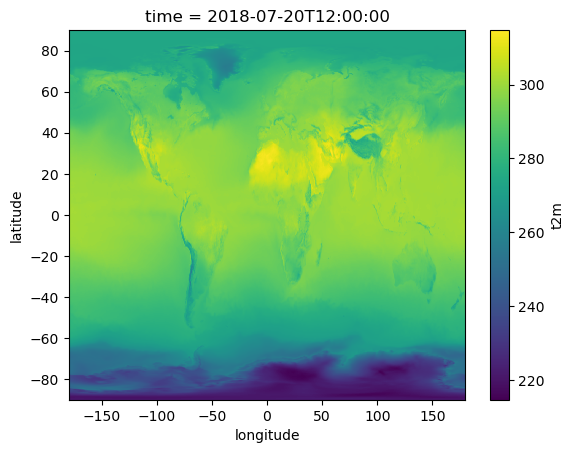

In [328]:
plot_graphs(dataset, 't2m', 807, 1, -1, -1)

### Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all years between 2001 and 2021. We can plot both the time-series of the temperature and a histogram of the values.

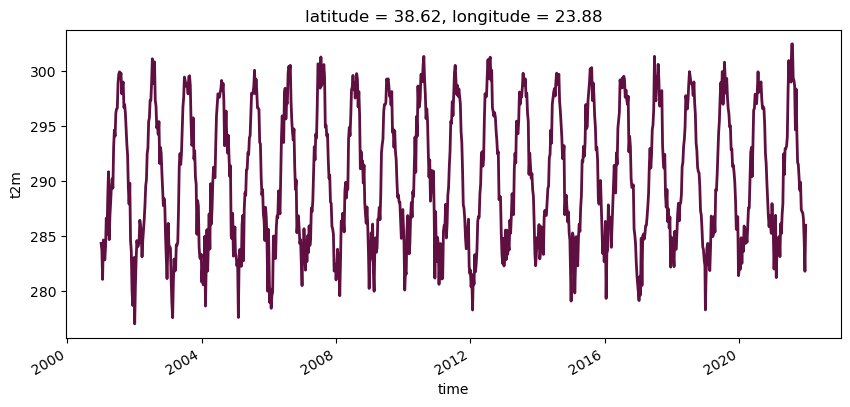

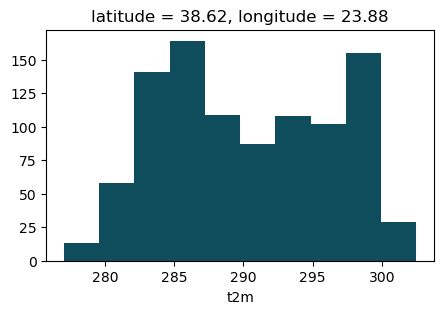

In [329]:
plot_graphs(dataset, 't2m', 0, 966, 205, 815)

### Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all periods in the year 2021.

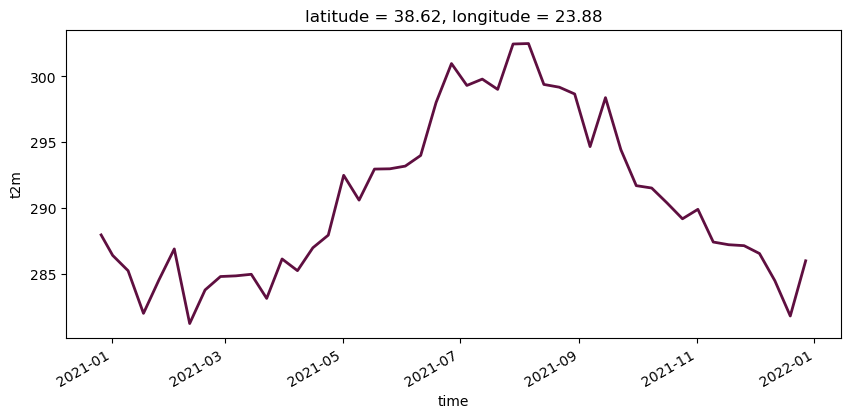

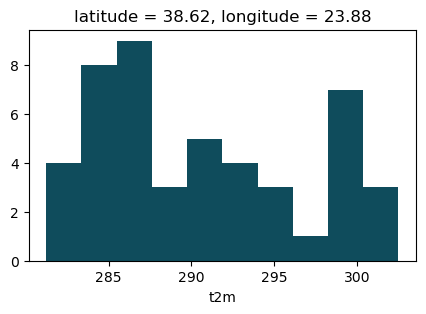

In [330]:
plot_graphs(dataset, 't2m', 919, 47, 205, 815)

### Potting the wind speed for the whole earth for a series of 8-days time periods.

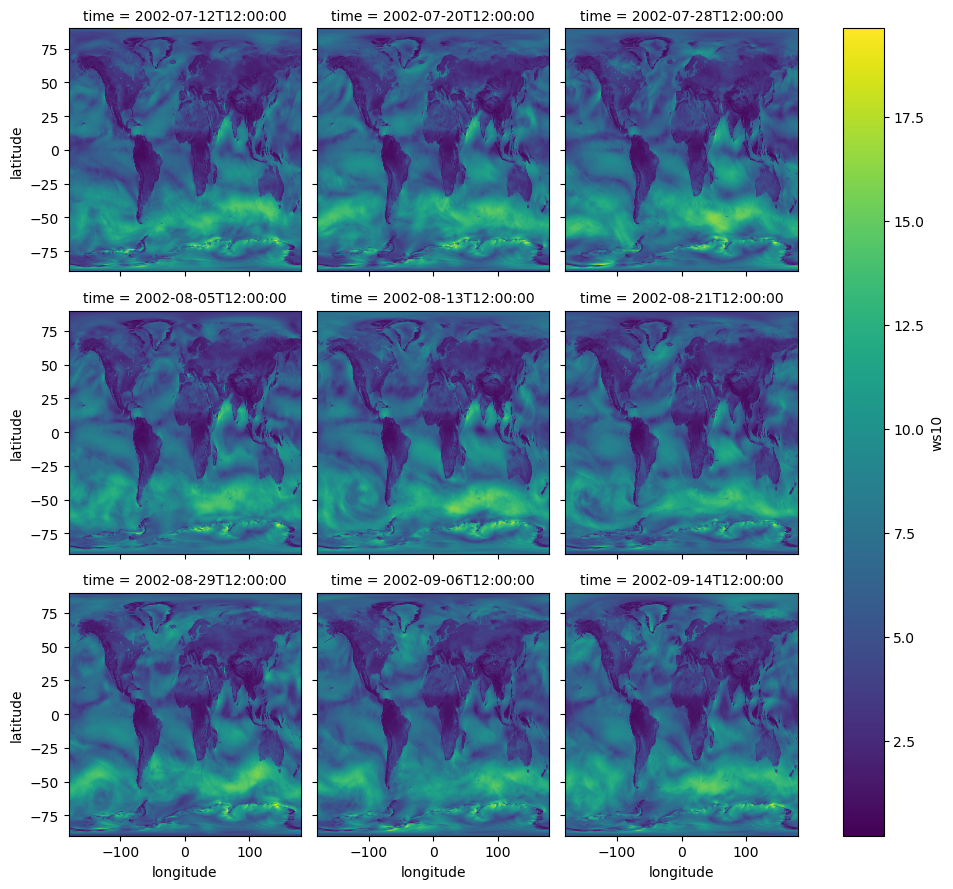

In [333]:
plot_graphs(dataset, 'ws10', 70, 9, -1, -1, col_wrap=3)

### Plotting the relative humidity for the whole earth for the same time periods as above.

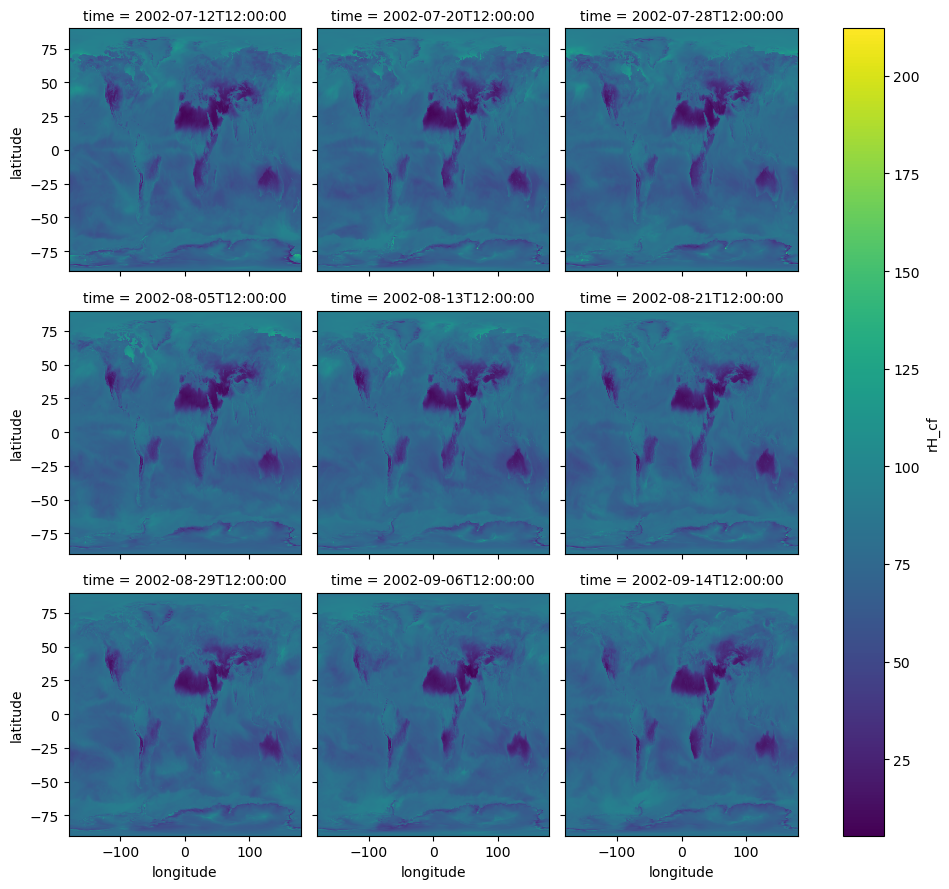

In [334]:
plot_graphs(dataset, 'rH_cf', 70, 9, -1, -1, col_wrap=3)

### Plotting the BurntArea for the whole earth for the same time periods as above. 

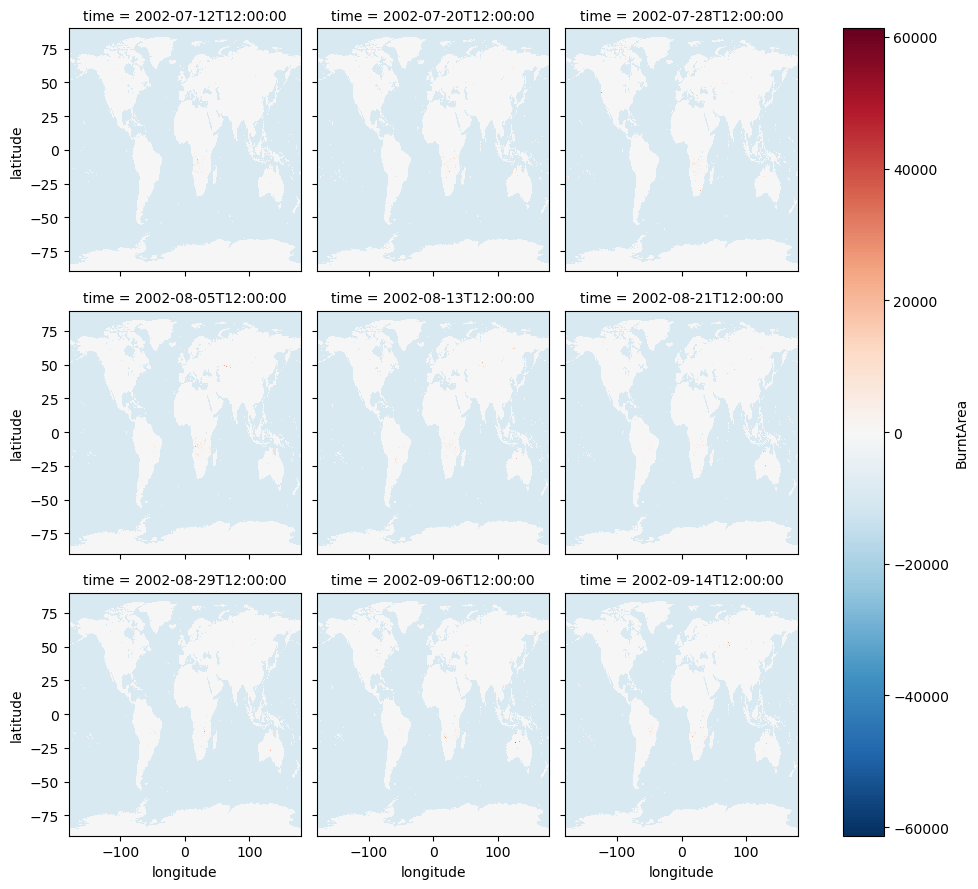

In [335]:
plot_graphs(dataset, 'BurntArea', 70, 9, -1, -1, col_wrap=3)